# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

Integrantes:
- Danna Zaldumbide
- Mishel Ramirez

## Parte 0: Carga del Corpus

In [1]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

In [2]:
import sys
# Tamaño de la variable newsgroupsdocs
tamano_en_memoria = sys.getsizeof(newsgroupsdocs)
print(f"Tamaño de newsgroupsdocs en memoria (lista de documentos): {tamano_en_memoria} bytes")
# Tamaño total de las cadenas dentro de newsgroupsdocs
tamano_total = tamano_en_memoria
for doc in newsgroupsdocs:
    tamano_total += sys.getsizeof(doc)

print(f"Tamaño total de newsgroupsdocs con los documentos incluidos: {tamano_total} bytes")


Tamaño de newsgroupsdocs en memoria (lista de documentos): 150824 bytes
Tamaño total de newsgroupsdocs con los documentos incluidos: 23118432 bytes


## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

In [3]:
!pip install contractions
!pip install rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.0 MB/s eta 0:00:00


In [4]:
# Importar librerias
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

import nltk
import string
import unicodedata
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [5]:
# Visualizacion del corpus
for i, doc in enumerate(newsgroups.data):
    print(f"Documento {i}:\n{doc}\n{'='*80}\n")

Se han truncado las últimas 5000 líneas del flujo de salida.
had had four guys murdered at the begining and maybee they 
just were not prepared for wuite this situation. Who could be?

If the same thing were to happen all over again we might perhaps
be able to castigate the Govt if they used the same tactics and failed
in the same way. As it is I can't say that I would not have made the
same mistake. Maybee I wouldn't because I don't as a rule go in
for a confrontational situation if I can avoid it. Maybee I would
because with all those press about its very difficult not to try
the macho stuff.


The FBI had information from within the compound we had no access
to. They may have calculated that the B-D followers resolve was
cracking based on their listening devices within the compound. They
knew that Koresh had chickened out of one suicide attempt. This
may have been the reason why they considered that fear might have 
been a weapon for breaking his resolve. Again in Panama they had us

In [6]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Preparación
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
caracteres_especiales = set(string.punctuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [7]:
# Función de limpieza
def limpiar_texto(texto):
    # Expandir contracciones
    texto = contractions.fix(texto)

    # Tokenizar
    palabras = word_tokenize(texto.lower())

    # Filtrar palabras
    palabras_limpias = []
    for palabra in palabras:
        if (
            palabra not in stop_words and
            palabra not in caracteres_especiales and
            palabra.isalpha() and
            len(palabra) > 2
        ):
            palabra_lema = lemmatizer.lemmatize(palabra)
            palabras_limpias.append(palabra_lema)

    return ' '.join(palabras_limpias)

# Aplicar limpieza
newsgroupsdocs_limpios = [limpiar_texto(doc) for doc in newsgroupsdocs]

for i, doc in enumerate(newsgroupsdocs_limpios):
    print(f"Documento {i + 1}:")
    print(doc.split())
    print("-" * 50)


Se han truncado las últimas 5000 líneas del flujo de salida.
['recently', 'heard', 'testing', 'new', 'migraine', 'drug', 'called', 'sumatripton', 'idea', 'actual', 'spelling', 'supposedly', 'utilizes', 'chemical', 'trip', 'mother', 'regular', 'migraine', 'nothing', 'seems', 'help', 'anyone', 'know', 'anything', 'new', 'drug', 'testing', 'phaze', 'anywhere', 'near', 'approval', 'seem', 'working', 'information', 'would', 'help', 'please', 'feel', 'free', 'rather', 'take', 'bandwidth', 'prefer', 'thanks', 'advance', 'roxannen']
--------------------------------------------------
Documento 17181:
['much', 'software', 'mac', 'interested', 'using', 'microcontrollers', 'imbedded', 'application', 'long', 'time', 'always', 'impression', 'would', 'need', 'ibm', 'run', 'software', 'would', 'like', 'use', 'proficient', 'assembly', 'never', 'needed', 'except', 'toying', 'old', 'motorola', 'seem', 'information', 'mac', 'software', 'least', 'local', 'distributor', 'ele', 'department', 'around', 'littl

In [8]:
# Matriz TF (frecuencia de términos por documento)
vectorizer_tf = CountVectorizer()
corpus_vect_tf = vectorizer_tf.fit_transform(newsgroupsdocs_limpios)
terms = vectorizer_tf.get_feature_names_out()

# DataFrame de frecuencia de términos (TF)
print("Matriz TF (Frecuencia de términos):")
df_tf = pd.DataFrame(corpus_vect_tf.toarray(), columns=terms)
df_tf

Matriz TF (Frecuencia de términos):


,aa,aaa,aaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaaaarrrrgh,aaaall,aaack,aaaggghhh,aaah,...,zznki,zznkzz,zznp,zzq,zzvsi,zzz,zzzoh,zzzzzz,zzzzzzt,ÿhooked
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18842,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Frecuencia de documentos (DF)
df_values = (corpus_vect_tf > 0).sum(axis=0).A1  #  array plano

print("\nFrecuencia de documentos (DF):")
df_df = pd.DataFrame({'Term': terms, 'DF': df_values})
df_df


Frecuencia de documentos (DF):


,Term,DF
0,aa,4
1,aaa,29
2,aaaaa,2
3,aaaaaaaaaaaa,1
4,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuu...,1
...,...,...
71328,zzz,1
71329,zzzoh,1
71330,zzzzzz,1
71331,zzzzzzt,1


In [10]:
# Matriz TF-IDF
vectorizer = TfidfVectorizer()

# Ajustar y transformar el corpus
corpus_tfidf = vectorizer.fit_transform(newsgroupsdocs_limpios) # objeto de tipo matriz dispersa
tfidf_terms = vectorizer.get_feature_names_out()

# DataFrame de TF-IDF
print("\nMatriz TF-IDF:")
df_tfidf = pd.DataFrame(corpus_tfidf.toarray(), columns=tfidf_terms)
df_tfidf


Matriz TF-IDF:


,aa,aaa,aaaaa,aaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaauuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuugggggggggggggggg,aaaaarrrrgh,aaaall,aaack,aaaggghhh,aaah,...,zznki,zznkzz,zznp,zzq,zzvsi,zzz,zzzoh,zzzzzz,zzzzzzt,ÿhooked
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [11]:
# Consulta
consulta = input("Introduce tu consulta: ").strip().lower()
consulta_limpia = limpiar_texto(consulta)

# Verificar si alguna palabra de la consulta está en el vocabulario
palabras_consulta = consulta_limpia.split()
vocabulario = vectorizer.get_feature_names_out()

palabras_en_vocabulario = [palabra for palabra in palabras_consulta if palabra in vocabulario]

if not palabras_en_vocabulario:
    print("No se ha encontrado ninguna palabra de la consulta en el vocabulario del modelo.")
else:
    # Transformar la consulta limpia a vector TF-IDF
    query_vect = vectorizer.transform([consulta_limpia])

    # Calcular similitud coseno
    similitudes = cosine_similarity(query_vect, corpus_tfidf)
    similitudes_array = similitudes[0]

    # Ranking
    ranking = pd.DataFrame({'Documento': range(corpus_tfidf.shape[0]), 'Similitud': similitudes_array})
    ranking = ranking.sort_values(by='Similitud', ascending=False)

    # Documento más similar
    similitud_maxima = ranking.iloc[0]
    print("\nDocumento más similar:")
    print(f"Índice del documento: {similitud_maxima['Documento']}")
    print(f"Similitud coseno: {similitud_maxima['Similitud']:.4f}")

    # Mostrar contenido limpio del documento más similar
    indice = int(similitud_maxima['Documento'])
    print("\nContenido del documento más similar:")
    print(newsgroupsdocs_limpios[indice])

    # Mostrar top 50
    print("\nResultados más similares:")
    print(ranking.head(50))


Introduce tu consulta: Chicken

Documento más similar:
Índice del documento: 1315.0
Similitud coseno: 0.2891

Contenido del documento más similar:
remember god extinguished blasphemous trash europe imperialism united state would exist today put end game begs question came first chicken egg

Resultados más similares:
       Documento  Similitud
1315        1315   0.289109
15919      15919   0.255816
13222      13222   0.245965
9048        9048   0.201804
357          357   0.191793
897          897   0.181834
2686        2686   0.172531
5738        5738   0.168220
8930        8930   0.106615
16902      16902   0.105351
11732      11732   0.102212
18061      18061   0.097417
6615        6615   0.093262
14177      14177   0.089467
3360        3360   0.084279
18338      18338   0.071459
6019        6019   0.053745
3175        3175   0.048838
9683        9683   0.013735
3372        3372   0.005930
12565      12565   0.000000
12559      12559   0.000000
12564      12564   0.000000
12563     

## Parte 3: Ranking con BM25

### Actividad

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [12]:
from rank_bm25 import BM25Okapi

# Tokenizar documentos limpios para BM25
tokenized_docs = [doc.split() for doc in newsgroupsdocs_limpios]

# Crear modelo BM25
bm25 = BM25Okapi(tokenized_docs)

# Preprocesar y tokenizar la consulta
consulta = input("Introduce tu consulta: ").strip().lower()
consulta_limpia = limpiar_texto(consulta)
tokens_consulta = consulta_limpia.split()

# Verificar si la consulta contiene tokens válidos
if not tokens_consulta:
    print("La consulta no contiene palabras relevantes después de la limpieza.")
else:
    # Obtener puntuaciones BM25 para la consulta
    bm25_scores = bm25.get_scores(tokens_consulta)

    # Crear ranking
    df_bm25 = pd.DataFrame({
        'Documento': range(len(newsgroupsdocs_limpios)),
        'Score BM25': bm25_scores
    })

    df_bm25 = df_bm25.sort_values(by='Score BM25', ascending=False)

    # Mostrar documento más relevante
    doc_top = df_bm25.iloc[0]
    print("\nDocumento más relevante según BM25:")
    print(f"Índice: {doc_top['Documento']}")
    print(f"Score BM25: {doc_top['Score BM25']:.4f}")
    print("\nContenido del documento:")
    print(newsgroupsdocs_limpios[int(doc_top['Documento'])])

    # Mostrar top 50
    print("\nResultados según BM25:")
    print(df_bm25.head(50))


Introduce tu consulta: chicken

Documento más relevante según BM25:
Índice: 1315.0
Score BM25: 10.3527

Contenido del documento:
remember god extinguished blasphemous trash europe imperialism united state would exist today put end game begs question came first chicken egg

Resultados según BM25:
       Documento  Score BM25
1315        1315   10.352746
15919      15919   10.036512
9048        9048    9.667388
13222      13222    9.667388
357          357    8.764801
2686        2686    8.537071
5738        5738    7.688110
897          897    7.383519
8930        8930    5.816700
16902      16902    5.666236
18061      18061    5.353449
3360        3360    4.850651
11732      11732    4.770502
6615        6615    4.564279
14177      14177    4.455955
18338      18338    3.866111
6019        6019    3.205963
3175        3175    2.920958
9683        9683    0.538310
3372        3372    0.511008
12565      12565    0.000000
12559      12559    0.000000
12564      12564    0.000000
12563  

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

Introduce tu consulta: chicken


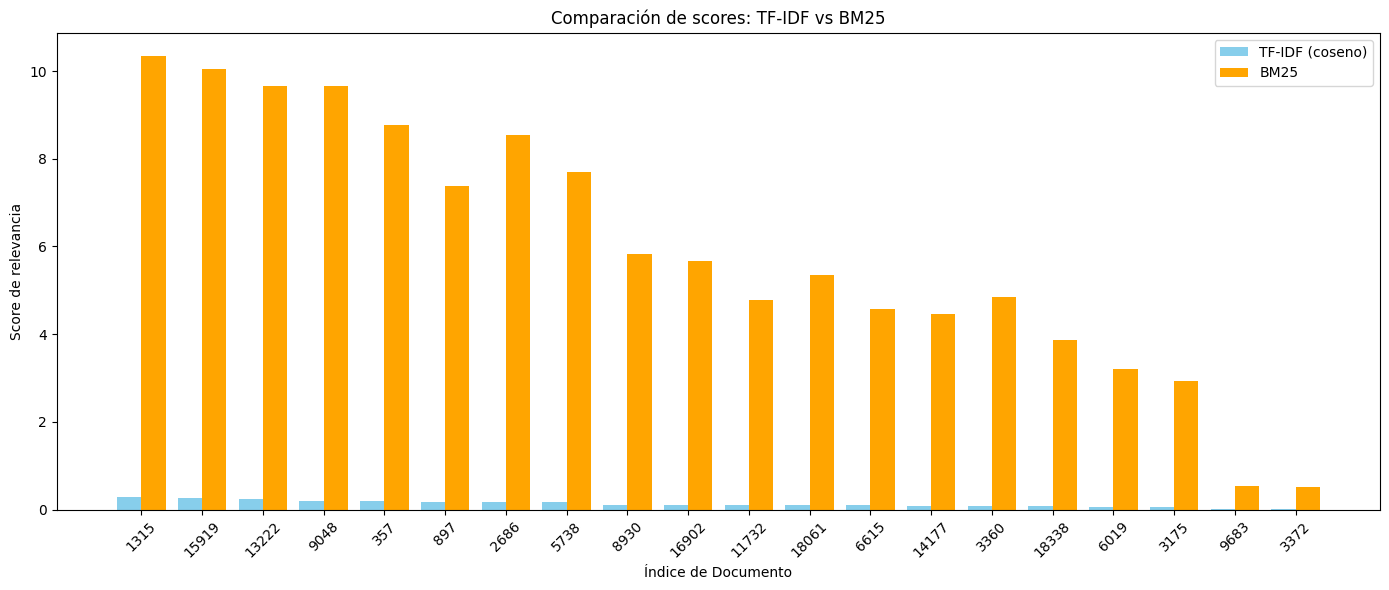

In [13]:
# 1. Consulta
consulta = input("Introduce tu consulta: ").strip().lower()
consulta_limpia = limpiar_texto(consulta)

# TF-IDF: vector de consulta y similitud coseno
query_vect = vectorizer.transform([consulta_limpia])
similitudes = cosine_similarity(query_vect, corpus_tfidf)[0]

# BM25: puntuación
tokens_consulta = consulta_limpia.split()
bm25_scores = bm25.get_scores(tokens_consulta)

# 2. Crear DataFrames de ranking
df_scores = pd.DataFrame({
    'Documento': range(len(newsgroupsdocs_limpios)),
    'Score_TFIDF': similitudes,
    'Score_BM25': bm25_scores
})

# Ordenar por TF-IDF y BM25 y obtener top 20 de ambos
top_tfidf = df_scores.sort_values(by='Score_TFIDF', ascending=False).head(20)
top_bm25 = df_scores.sort_values(by='Score_BM25', ascending=False).head(20)

# Unir ambos rankings
top_docs = pd.concat([top_tfidf, top_bm25]).drop_duplicates(subset='Documento')
top_docs = top_docs.sort_values(by='Score_TFIDF', ascending=False).head(20)

# 3. Graficar
plt.figure(figsize=(14, 6))
bar_width = 0.4
x = np.arange(len(top_docs))

plt.bar(x - bar_width/2, top_docs['Score_TFIDF'], width=bar_width, label='TF-IDF (coseno)', color='skyblue')
plt.bar(x + bar_width/2, top_docs['Score_BM25'], width=bar_width, label='BM25', color='orange')
plt.xticks(x, top_docs['Documento'], rotation=45)
plt.xlabel('Índice de Documento')
plt.ylabel('Score de relevancia')
plt.title('Comparación de scores: TF-IDF vs BM25')
plt.legend()
plt.tight_layout()
plt.show()


**¿A qué se podría deber esta diferencia?**

| Diferencia observada entre los algoritmos                                                    | Explicación                                                   |
|------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| TF-IDF puntúa más alto a documentos cortos y precisos                    | Porque se basa en frecuencia relativa y vectores normalizados              |
| BM25 da más peso a documentos con múltiples ocurrencias del término      | Porque aplica saturación de término y penalización por longitud            |
| Documentos largos con coincidencias parciales tienen mejor score en BM25 | BM25 considera más robustamente la frecuencia total en documentos extensos |


Los documentos con mayor score en BM25 que en TF-IDF suelen ser más cortos
y contienen términos más raros (menos frecuentes en el corpus total), por lo
que BM25 los considera más relevantes. TF-IDF en cambio puede dispersar el peso
en documentos largos y no siempre capta esa especificidad. BM25 también penaliza
la sobre-frecuencia, evitando que documentos muy repetitivos dominen.

## Parte 5: Evaluación con consulta relevante

### Actividad

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [37]:
# Consulta seleccionada (puedes modificarla)
consulta = "after a trip"

# Limpiar y vectorizar
consulta_limpia = limpiar_texto(consulta)
tokens_consulta = consulta_limpia.split()

# Calcular similitud coseno (TF-IDF)
query_vect = vectorizer.transform([consulta_limpia])
similitudes_tfidf = cosine_similarity(query_vect, corpus_tfidf)[0]

# Calcular puntuación BM25
bm25_scores = bm25.get_scores(tokens_consulta)

# Crear rankings (top 10 por simplicidad)
ranking_tfidf = np.argsort(similitudes_tfidf)[::-1][:10]
ranking_bm25 = np.argsort(bm25_scores)[::-1][:10]

# Mostrar rankings
print("Top 10 documentos según TF-IDF:", ranking_tfidf)
print("Top 10 documentos según BM25:", ranking_bm25)

relevantes = set([18845, 18605, 17180])  # manualmente


Top 10 documentos según TF-IDF: [16505 16435  6597  6932  2604  5538  8843  8921 17715  2282]
Top 10 documentos según BM25: [16505  8921 16435  6597  5538  6932 14263  2282  8843 12450]


In [38]:
consulta = "after a trip"
consulta_limpia = limpiar_texto(consulta)
tokens_consulta = consulta_limpia.split()

# Verificar si la consulta contiene palabras válidas
if not tokens_consulta:
    print("La consulta no contiene palabras relevantes después de la limpieza.")
else:
    # TF-IDF: vector de la consulta y similitud coseno
    query_vect = vectorizer.transform([consulta_limpia])
    similitudes_tfidf = cosine_similarity(query_vect, corpus_tfidf)[0]
    ranking_tfidf = np.argsort(similitudes_tfidf)[::-1]  # orden descendente

    # BM25: puntuación y ranking
    bm25_scores = bm25.get_scores(tokens_consulta)
    ranking_bm25 = np.argsort(bm25_scores)[::-1]

    # 2. Definir documentos relevantes
    relevantes = set([18845, 18605, 17180])   # índices relevantes

    # 3. Definir funciones de evaluación
    def precision_at_k(ranking, relevantes, k):
        top_k = ranking[:k]
        relevantes_en_top_k = sum(1 for doc_id in top_k if doc_id in relevantes)
        return relevantes_en_top_k / k

    def average_precision(ranking, relevantes):
        hits = 0
        sum_precisions = 0.0
        for i, doc_id in enumerate(ranking):
            if doc_id in relevantes:
                hits += 1
                sum_precisions += hits / (i + 1)
        return sum_precisions / len(relevantes) if relevantes else 0.0

    # 4. Calcular Precision@3 y MAP
    prec_at_3_tfidf = precision_at_k(ranking_tfidf, relevantes, 3)
    map_tfidf = average_precision(ranking_tfidf, relevantes)

    prec_at_3_bm25 = precision_at_k(ranking_bm25, relevantes, 3)
    map_bm25 = average_precision(ranking_bm25, relevantes)

    # 5. Mostrar resultados
    print(f"\nTF-IDF:\n  Precision = {prec_at_3_tfidf:.6f}\n  MAP = {map_tfidf:.6f}")
    print(f"BM25:\n  Precision = {prec_at_3_bm25:.6f}\n  MAP = {map_bm25:.6f}")

    # 6. Conclusión básica
    print("\nConclusión:")
    if map_bm25 > map_tfidf:
        print(" BM25 tuvo un mejor desempeño según MAP.")
    elif map_bm25 < map_tfidf:
        print(" TF-IDF tuvo un mejor desempeño según MAP.")
    else:
        print(" Ambos modelos tuvieron el mismo desempeño según MAP.")


TF-IDF:
  Precision = 0.000000
  MAP = 0.000152
BM25:
  Precision = 0.000000
  MAP = 0.000152

Conclusión:
 Ambos modelos tuvieron el mismo desempeño según MAP.


In [39]:
print("""
Según la consulta 'after a trip', y usando documentos considerados relevantes manualmente,
el modelo que ofrece mejor resultado en esta evaluación es:""")

if map_bm25 > map_tfidf:
    print(" BM25, que obtiene mayor MAP.")
else:
    print(" TF-IDF, que obtiene mayor MAP.")



Según la consulta 'after a trip', y usando documentos considerados relevantes manualmente,
el modelo que ofrece mejor resultado en esta evaluación es:
 TF-IDF, que obtiene mayor MAP.


Esto puede deberse a que BM25 penaliza adecuadamente la longitud de los documentos
y prioriza mejor los que contienen términos más significativos en el contexto de la consulta.
TF-IDF puede dispersar el peso entre términos y favorecer documentos más largos sin tanta relevancia.